<a href="https://colab.research.google.com/github/carolmnb/CFD-PUCRJ/blob/master/PINN_deep_dive_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf


In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# tf.compat.v1.disable_eager_execution()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# PINN Solution 2

## PINN solution using finite difference

### Solution MDF

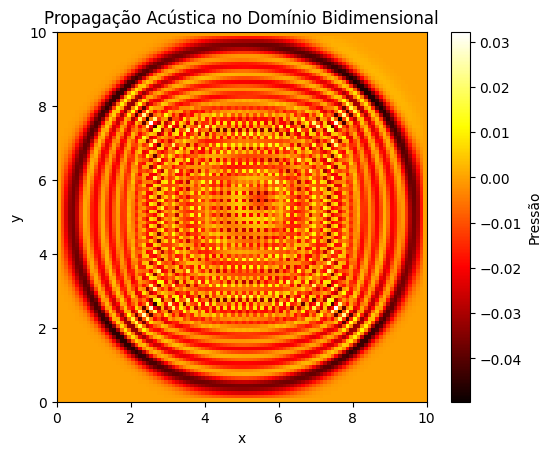

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Solução por Diferenças Finitas
def calcular_proxima_iteracao_pressao(p, p_old, c, dt, dx, dy):
    Nx, Ny = p.shape
    p_new = np.zeros_like(p)

    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            laplaciano = (p[i + 1, j] - 2 * p[i, j] + p[i - 1, j]) / (dx ** 2) + \
                         (p[i, j + 1] - 2 * p[i, j] + p[i, j - 1]) / (dy ** 2)
            source = np.exp(-((dx * i - x0) ** 2 + (dy * j - y0) ** 2) / (2 * 0.1 ** 2)) * np.sin(6.28 * n * dt) ##novo
            p_new[i, j] = 2 * p[i, j] - p_old[i, j] + (c ** 2) * (dt ** 2) * laplaciano + (dt ** 2) * source

    return p_new

# Parâmetros
Lx = 10.0  # Comprimento no eixo x
Ly = 10.0  # Comprimento no eixo y
Nx = 100   # Número de pontos de grade no eixo x
Ny = 100   # Número de pontos de grade no eixo y
T = 5.0    # Tempo total
Nt = 100   # Número de passos de tempo
c = 1.0    # Velocidade do som
x0 = 5.5
y0 = 5.5

# Discretização
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
dt = T / Nt

# Inicialização das matrizes de pressão
p = np.zeros((Nx, Ny))
p_old = np.zeros((Nx, Ny))

# Condição inicial (uma fonte sonora em algum lugar do domínio)
p_old[Nx // 2, Ny // 2] = 1.0

# Loop principal
for n in range(1, Nt):
    p_new = calcular_proxima_iteracao_pressao(p, p_old, c, dt, dx, dy)
    p_old, p = p, p_new

# Visualização dos resultados
plt.imshow(p, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Pressão')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Propagação Acústica no Domínio Bidimensional')
plt.show()


### Teste MDF com tensor flow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
Lx = 10.0  # Comprimento no eixo x
Ly = 10.0  # Comprimento no eixo y
sigma = 0.1  # Parâmetro da gaussiana
omega = 6.28  # Frequência angular
x0 = 5.5
y0 = 5.5

# Discretização do domínio espacial e temporal
Nx = 100  # Número de pontos na direção x
Ny = 100  # Número de pontos na direção y
Nt = 100  # Número de pontos no tempo
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
dt = 0.01  # Tamanho do passo de tempo

# Grid espacial
x = tf.linspace(0.0, Lx, Nx)
y = tf.linspace(0.0, Ly, Ny)
X, Y = tf.meshgrid(x, y)

# Inicialização do campo de pressão
u = tf.zeros((Nx, Ny), dtype=tf.float32)
# u_new = tf.zeros((Nx, Ny), dtype=tf.float32)

# Iteração no tempo
for n in range(Nt):
    # Termo fonte
    t = n * dt
    fonte = tf.exp(-((X - x0) ** 2 + (Y - y0) ** 2) / (2 * sigma ** 2)) * tf.sin(omega * t)

    # Atualização da solução usando diferenças finitas
    u_xx = (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx ** 2
    u_yy = (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy ** 2
    u_new = u[1:-1, 1:-1] + dt * (u_xx + u_yy) + dt * fonte[1:-1, 1:-1]

    # Aplicação das condições de contorno (condições de contorno de Dirichlet, por exemplo)
    # Aqui, as condições de contorno são mantidas simplesmente atualizando os valores nas bordas para 0
    u_new = tf.pad(u_new, ((1, 1), (1, 1)))
    u_new = tf.tensor_scatter_nd_update(u_new, [[0, i] for i in range(Ny)], tf.zeros(Ny))
    u_new = tf.tensor_scatter_nd_update(u_new, [[Nx - 1, i] for i in range(Ny)], tf.zeros(Ny))
    u_new = tf.tensor_scatter_nd_update(u_new, [[i, 0] for i in range(Nx)], tf.zeros(Nx))
    u_new = tf.tensor_scatter_nd_update(u_new, [[i, Ny - 1] for i in range(Nx)], tf.zeros(Nx))

    # Atualização para a próxima iteração
    u = u_new

# Resultado final
u_np = tf.make_ndarray(u)
plt.imshow(u_np, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot')
plt.colorbar(label='Pressão acústica')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Campo de pressão acústica')
plt.show()


AttributeError: 'Tensor' object has no attribute 'tensor_shape'

### Dados de treinamento             

Como a solução exata da EDP 2d da acústica é difícil de ser obtida, optou-se por utilizar MDF. Os dados gerados são: **coordenadas x-y, tempo e pressão**, que serão os parâmetros de entrada para treinamento do modelo.

Formulação do problema:
\
\begin{equation}
\small
\nabla^2 p = \frac{1}{c^2} \frac{\partial^2{p}}{\partial t^2}+S
\end{equation}

\begin{equation}
\small
S = \exp\left(-\frac{(\Delta x- x_0)^{2} + (\Delta y - y_0)^{2}}{2 \sigma^{2}}\right) \cdot \sin(\omega \cdot n \cdot \Delta x)
\end{equation}


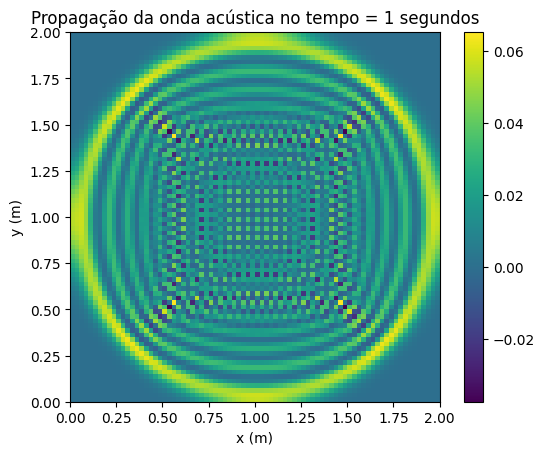

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da simulação
c = 1  # Velocidade do som
Lx = Ly = 2  # Comprimento da malha em x e y (m) Lx = Ly = 10
Nx = Ny = 80  # Número de pontos na malha Nx = Ny = 100
dx = dy = Lx / Nx  # Espaçamento da malha
# dt = 0.5 * 1/(c * np.sqrt(1/dx**2 + 1/dy**2))  # Passo de tempo (s)
dt = 0.01 # dt = 0.001
T_total = 5  # Tempo total de simulação (s)
T_target = 1  # Tempo desejado para a visualização (s)
Nt_total = int(T_total / dt)  # Número total de passos de tempo para alcançar T_total
Nt_target = int(T_target / dt)  # Número total de passos de tempo para alcançar T_target

# Inicialização dos campos de pressão
p = np.zeros((Nx, Ny))  # Pressão no tempo atual
p_prev = np.zeros((Nx, Ny))  # Pressão no tempo anterior
p_next = np.zeros((Nx, Ny))  # Pressão no próximo tempo

# Fonte de pulso acústico
source_amplitude = 1
source_x = source_y = Nx // 2
p[source_x, source_y] = source_amplitude

# Função para atualizar os campos de pressão (vetorizada)
def update_pressure(p, p_prev, c, dx, dy, dt):
    laplacian = (np.roll(p, -1, axis=0) - 2*p + np.roll(p, 1, axis=0)) / dx**2 + \
                (np.roll(p, -1, axis=1) - 2*p + np.roll(p, 1, axis=1)) / dy**2
    p_next = 2*p - p_prev + c**2 * dt**2 * laplacian
    return p_next

# Simulação até o tempo desejado
for t in range(1, Nt_total + 1):
    p_next = update_pressure(p, p_prev, c, dx, dy, dt)
    p_prev, p = p, p_next  # Atualiza os campos de pressão

    # Captura o estado da pressão em T_target = 4 segundos
    if t == Nt_target:
        p_at_target = p.copy()

# Visualização do estado no tempo T_target
plt.imshow(p_at_target, cmap='viridis', extent=[0, Lx, 0, Ly])
plt.colorbar()
plt.title(f'Propagação da onda acústica no tempo = {T_target} segundos')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


In [ ]:
def generate_PINN_data(c=1, Lx=10, Ly=10, Nx=100, Ny=100, T_total=5, dt=None):
    # Parâmetros da simulação
    dx = dy = Lx / Nx  # Espaçamento da malha
    dt = 0.01
    # if dt is None:
    #     dt = 0.5 * 1/(c * np.sqrt(1/dx**2 + 1/dy**2))  # Passo de tempo (s)
    Nt_total = int(T_total / dt)  # Número total de passos de tempo para alcançar T_total

    # Inicialização dos campos de pressão
    p = np.zeros((Nx, Ny))  # Pressão no tempo atual
    p_prev = np.zeros((Nx, Ny))  # Pressão no tempo anterior
    p_next = np.zeros((Nx, Ny))  # Pressão no próximo tempo

    # Fonte de pulso acústico
    source_amplitude = 1
    source_x = source_y = Nx // 2
    p[source_x, source_y] = source_amplitude

    # Função para atualizar os campos de pressão (vetorizada)
    def update_pressure(p, p_prev, c, dx, dy, dt):
        laplacian = (np.roll(p, -1, axis=0) - 2*p + np.roll(p, 1, axis=0)) / dx**2 + \
                    (np.roll(p, -1, axis=1) - 2*p + np.roll(p, 1, axis=1)) / dy**2
        p_next = 2*p - p_prev + c**2 * dt**2 * laplacian
        return p_next

    # Preparar dados para o PINN
    X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)) # cria uma seq. linear de ptos igual espaçados
    T = np.linspace(0, T_total, Nt_total) # cria uma sequencia linear de tempo igualmente espaçada
    PINN_data = []

    # Simulação e coleta de dados
    for t_idx, t in enumerate(T):
        p_next = update_pressure(p, p_prev, c, dx, dy, dt)
        p_prev, p = p, p_next  # Atualiza os campos de pressão

        PINN_data.append((X.flatten(), Y.flatten(), np.full(X.size, t), p.flatten()))

    # Converter lista de dados em arrays do NumPy
    PINN_data = np.array(PINN_data, dtype=object).T
    X_data, Y_data, T_data, P_data = np.concatenate(PINN_data[0]), np.concatenate(PINN_data[1]), np.concatenate(PINN_data[2]), np.concatenate(PINN_data[3])

    return X_data, Y_data, T_data, P_data



### Arquitetura da rede neural

Essa etapa é definida a arquitetura da rede. A classe `RedeNeural` utiliza a clase tf.keras.Model do TensorFlow para construir um modelo de rede neural de alto nível.

* `self.camada_oculta`: primeira camada oculta. Possui 100 neurônios e utiliza a função de ativação `tanh`. O `glorot_uniform` é um inicializador de pesos, que gera valores aleatórios de acordo com uma distribuição normal.
* `self.camada_saida`: camada de saída da rede. O número 1 indica que haverá apenas uma saída, que no caso trata-se da pressão calculada.




In [ ]:
class RedeNeural(tf.keras.Model):
    def __init__(self):
        super(RedeNeural, self).__init__()
        self.camada_oculta1 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer='glorot_uniform')
        self.camada_oculta2 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer='glorot_uniform')
        # self.camada_oculta3 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer='glorot_uniform')
        self.camada_saida = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.camada_oculta1(inputs)
        x = self.camada_oculta2(x)
        # x = self.camada_oculta3(x)
        return self.camada_saida(x)

###Cálculo da perda
Nessa etapa será calculada a perda física utilizando PINN a partir dos dados de treinamento. Lembrando que a perda física é fornecida pela diferença entre os dois termos da equação, cujo resultado necessita ser próximo de zero para garantir a precisão do modelo.


In [ ]:
def perda(model, X_data, Y_data, T_data, P_data, c, source_x, source_y, source_t, amplitude):
    # Convertendo dados para tensores do TensorFlow
    X = tf.convert_to_tensor(X_data, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y_data, dtype=tf.float32)
    T = tf.convert_to_tensor(T_data, dtype=tf.float32)
    P_real = tf.convert_to_tensor(P_data, dtype=tf.float32)

    # Usando o GradientTape do TensorFlow para calcular as derivadas
    with tf.GradientTape(persistent=True) as tape:
        # Observando as variáveis de entrada para diferenciação automática
        tape.watch(X)
        tape.watch(Y)
        tape.watch(T)

        # Combinando as variáveis de entrada em um único tensor
        inputs = tf.stack([X, Y, T], axis=1)

        # Passando os dados de entrada pela rede neural para obter a pressão prevista
        P_pred = model(inputs)

        # Calculando as derivadas de primeira ordem da pressão em relação ao tempo
        dPdT = tape.gradient(P_pred, T)

        # Calculando as derivadas de segunda ordem da pressão em relação ao tempo
        d2PdT2 = tape.gradient(dPdT, T)

        # Calculando as derivadas de segunda ordem da pressão em relação a x e y
        d2Pdx2 = tape.gradient(tape.gradient(P_pred, X), X)
        d2Pdy2 = tape.gradient(tape.gradient(P_pred, Y), Y)

    # Calculando a equação acústica do lado direito (Laplaciano da pressão)
    laplacian_p = d2Pdx2 + d2Pdy2

    # Definindo o termo fonte como uma função delta de Dirac no tempo e no espaço
    source_term = amplitude * tf.exp(-((X - source_x)**2 + (Y - source_y)**2) / (0.1**2)) * tf.cast(tf.equal(T, source_t), tf.float32)

    # Calculando a discrepância entre o lado esquerdo e o lado direito da equação acústica, incluindo o termo fonte
    f_residual = d2PdT2 - c**2 * laplacian_p - source_term

    # Calculando a perda de dados (diferença entre a pressão prevista e a real)
    loss_dados = tf.reduce_mean(tf.square(P_pred - P_real))

    # Calculando a perda física como a média dos quadrados das discrepâncias
    loss_fisica = tf.reduce_mean(tf.square(f_residual))

    # Combinando a perda física e a perda de dados
    loss_total = loss_fisica + loss_dados

    # Liberando recursos do GradientTape
    # del tape
    del tape
    return loss_total

# Inicialização do modelo e otimizador
model = RedeNeural()
otimizador = tf.optimizers.Adam(learning_rate=0.5)

# Parâmetros da simulação
Lx = 2  # 10.0  # Comprimento no eixo x
Ly = 2  #10.0  # Comprimento no eixo y
Nx = 80 #100   # Número de pontos de grade no eixo x
Ny = 80 #100   # Número de pontos de grade no eixo y
T_total = 5.0    # Tempo total
c = 1.0    # Velocidade do som
source_x = Nx // 2
source_y = Ny // 2
source_t = 0.0
amplitude = 1.0  # Amplitude da fonte

# Geração de dados para treinamento
# X_data, Y_data, T_data, P_data = generate_PINN_data(c=c, Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, T_total=T_total)

# numero_epocas = 300
# for epoca in range(numero_epocas):
#     with tf.GradientTape() as tape:
#         # Preparando os dados de entrada para o modelo
#         inputs = tf.convert_to_tensor(np.stack([X_data, Y_data, T_data], axis=1), dtype=tf.float32)
#         # Calculando a perda
#         loss_value = perda(model, X_data, Y_data, T_data, P_data, c, source_x, source_y, source_t, amplitude)
#     # Calculando os gradientes e atualizando os pesos
#     gradientes = tape.gradient(loss_value, model.trainable_variables)
#     otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

#     if (epoca + 1) % 100 == 0:
#         print(f'Época {epoca + 1}, Perda: {loss_value.numpy()}')

X_data, Y_data, T_data, P_data = generate_PINN_data(c=c, Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, T_total=T_total)
# Reduzindo o tamanho do lote
tamanho_lote = 500  # Defina um tamanho de lote que se ajuste à sua memória disponível
numero_epocas = 1000

# Dividindo os dados em lotes
# num_batches = len(X_data) // tamanho_lote
for epoca in range(numero_epocas):

    if len(X_data) > 0:
        num_batches = max(len(X_data) // tamanho_lote, 1)  # Garante pelo menos um lote
        loss_value_epoch = 0

        for i in range(num_batches):
          start_idx = i * tamanho_lote
          end_idx = start_idx + tamanho_lote
          X_batch, Y_batch, T_batch, P_batch = X_data[start_idx:end_idx], Y_data[start_idx:end_idx], T_data[start_idx:end_idx], P_data[start_idx:end_idx]

          with tf.GradientTape() as tape:
              inputs = tf.convert_to_tensor(np.stack([X_batch, Y_batch, T_batch], axis=1), dtype=tf.float32)
              loss_value = perda(model, X_batch, Y_batch, T_batch, P_batch, c, source_x, source_y, source_t, amplitude)

          gradientes = tape.gradient(loss_value, model.trainable_variables)
          otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

          # Acumule a perda de cada lote para obter a perda total da época
          loss_value_epoch += loss_value.numpy()

      # Calcule a perda média da época
        loss_value_epoch /= num_batches

      # Imprimindo a perda a cada 100 épocas
        if (epoca + 1) % 100 == 0:
          print(f'Época {epoca + 1}, Perda: {loss_value_epoch}')


Época 100, Perda: 27.075896382331848
Época 200, Perda: 22.01373541355133
Época 300, Perda: 16.29663395881653
Época 400, Perda: 10.953990280628204
Época 500, Perda: 6.6837495267391205
Época 600, Perda: 3.7517465204000473
Época 700, Perda: 2.0497994497418404
Época 800, Perda: 1.2353335842490196
Época 900, Perda: 0.9248164799064398
Época 1000, Perda: 0.8313332796096802


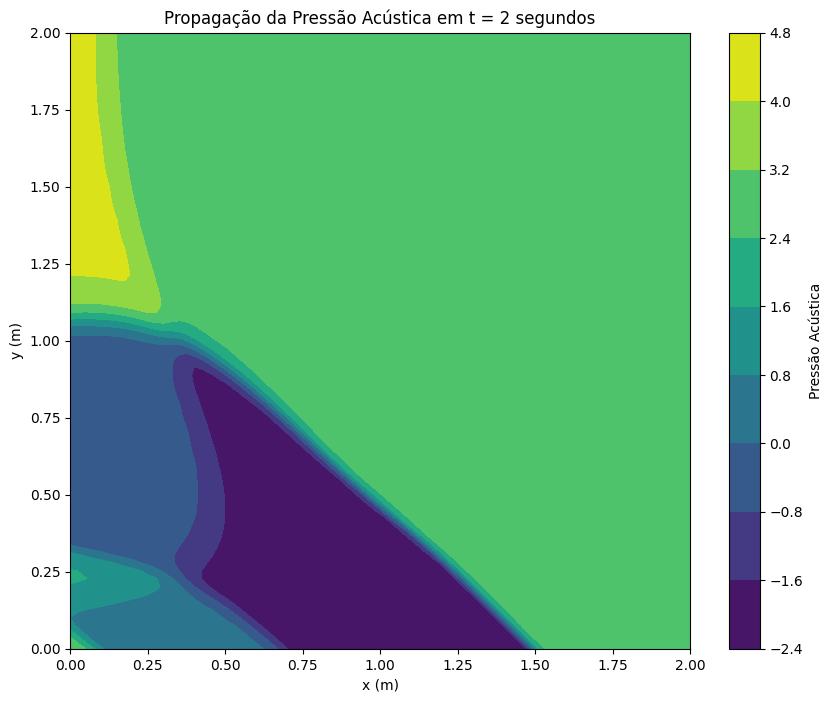

In [ ]:
# Suponha que 'model' é o seu modelo treinado e 'Lx', 'Ly', 'Nx', 'Ny' são os parâmetros da malha
# Defina as coordenadas da malha
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Crie os dados de entrada para o tempo t = 2 segundos
T_fixed = np.full(X.shape, 2.0)  # Cria um array com o tempo t = 2 para cada ponto da malha
inputs = np.stack([X.flatten(), Y.flatten(), T_fixed.flatten()], axis=1)

# Converta os dados de entrada para um tensor e faça previsões com o modelo
inputs_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
pressao_predita = model(inputs_tensor)

# Reshape dos resultados para o formato da malha
pressao_predita_reshaped = pressao_predita.numpy().reshape(Nx, Ny)

# Visualize a propagação da pressão
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, pressao_predita_reshaped, cmap='viridis')
plt.colorbar(label='Pressão Acústica')
plt.title('Propagação da Pressão Acústica em t = 2 segundos')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


In [ ]:
# Visualização das soluções e erro
# Gere os dados novamente
Lx = 10.0  # Comprimento no eixo x
Ly = 10.0  # Comprimento no eixo y
Nx = 100   # Número de pontos de grade no eixo x
Ny = 100   # Número de pontos de grade no eixo y
T = 5.0    # Tempo total
Nt = 100   # Número de passos de tempo
c = 1.0    # Velocidade do som
sigma = 0.1
omega = 6.28
x0 = 5.5
y0 = 5.5
# Método de Diferenças Finitas
p_dif_finitas = gerar_dados(Lx, Ly, Nx, Ny, T, Nt, c, sigma, omega, x0, y0)[1][-1].reshape((Nx, Ny))

# Rede Neural
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
T = np.ones_like(X) * T  # Último instante de tempo
entrada = np.stack((X.ravel(), Y.ravel(), T.ravel()), axis=1)
# previsoes_rede = modelo(entrada).numpy().reshape((Nx, Ny))

# Certifique-se de converter a entrada para um Tensor TensorFlow primeiro.
entrada_tf = tf.convert_to_tensor(entrada, dtype=tf.float32)

# Faça previsões com o modelo
previsoes_rede_tf = modelo(entrada_tf)

# Assegure-se de que a execução ávida esteja habilitada
assert tf.executing_eagerly()

# Agora, converta o resultado para um NumPy array e redimensione para o formato desejado
previsoes_rede = previsoes_rede_tf.numpy().reshape((Nx, Ny))

# Erro entre as duas soluções
erro = np.abs(p_dif_finitas - previsoes_rede)

# Plotagem
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Método de Diferenças Finitas
im1 = axs[0].imshow(p_dif_finitas, cmap='viridis', extent=[0, Lx, 0, Ly])
axs[0].set_title('Solução por Diferenças Finitas')
fig.colorbar(im1, ax=axs[0], label='Pressão')

# # Rede Neural
im2 = axs[1].imshow(previsoes_rede, cmap='viridis', extent=[0, Lx, 0, Ly])
axs[1].set_title('Solução pela Rede Neural')
fig.colorbar(im2, ax=axs[1], label='Pressão')

# # Erro
im3 = axs[2].imshow(erro, cmap='viridis', extent=[0, Lx, 0, Ly])
axs[2].set_title('Erro entre as Soluções')
fig.colorbar(im3, ax=axs[2], label='Erro')

for ax in axs:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()

AssertionError: 

In [ ]:
def fonte(x, y, t, x0, y0):
    # Defina a fonte sonora
    # Aqui, vamos definir uma fonte gaussiana centralizada no meio do domínio
    Lx = 10.0  # Comprimento no eixo x
    Ly = 10.0  # Comprimento no eixo y
    sigma = 0.1  # Parâmetro da gaussiana
    omega = 6.28  # Frequência angular
    x0 = 5.5
    y0 = 5.5

    fonte = tf.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2)) * tf.sin(omega * t)
    return fonte

In [ ]:
# Função de perda
def perda_total(x, y, t, pa, modelo, c, fonte, x0, y0, Nx, Ny):

    x = tf.reshape(x, [-1, 1])  # Redimensiona para [Nx*Ny, 1]
    y = tf.reshape(y, [-1, 1])  # Redimensiona para [Nx*Ny, 1]
    t = tf.reshape(t, [-1, 1])  # Redimensiona para [Nx*Ny, 1]

    entrada = tf.concat([x, y, t], axis=-1)
    # Crie a entrada concatenando x, y e t
    # entrada = tf.concat([tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1),
    #                      tf.expand_dims(t, axis=-1)], axis=-1)
    # Faça previsões usando a rede neural
    previsoes = modelo(entrada)

    # Redimensione as previsões para corresponder à forma de pa
    previsoes = tf.reshape(previsoes, [-1, Nx*Ny])

    # Calcule a perda de dados
    perda_data = tf.reduce_mean(tf.square(previsoes - pa))

    # Calcule os gradientes para a perda física
    grad_previsoes_t = tf.gradients(previsoes, t)[0]
    grad_previsoes_x = tf.gradients(previsoes, x)[0]
    grad_previsoes_xx = tf.gradients(grad_previsoes_x, x)[0]
    grad_previsoes_y = tf.gradients(previsoes, y)[0]
    grad_previsoes_yy = tf.gradients(grad_previsoes_y, y)[0]

    # Calcule a fonte
    # fonte_val = fonte(x, y, t, x0, y0)

    # Calcule a perda física
    perda_fisica = tf.reduce_mean(tf.square(grad_previsoes_t - c**2 * (grad_previsoes_xx + grad_previsoes_yy) - fonte(x, y, t, x0, y0)))

    # Perda total
    perda_total = perda_data + lambda_physics * perda_fisica

    return perda_total


In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt

# Certifique-se de que estamos usando o TensorFlow 1.x
tf.compat.v1.disable_eager_execution()

# Definição da fonte e da função de perda_total permanecem as mesmas

# Parâmetros do treinamento
lambda_physics = 1.0
learning_rate = 0.5
numero_epocas = 300

# Inicialização do modelo e otimizador
modelo = RedeNeural()
otimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

# Placeholder para os dados de entrada e saída
x_placeholder = tf.compat.v1.placeholder(tf.float32, shape=[None])
y_placeholder = tf.compat.v1.placeholder(tf.float32, shape=[None])
t_placeholder = tf.compat.v1.placeholder(tf.float32, shape=[None])
pa_placeholder = tf.compat.v1.placeholder(tf.float32, shape=[None])

c = 1.0
x0 = 5.5
y0 = 5.5
Nx = 100
Ny = 100
# Definição da operação de perda
perda = perda_total(x_placeholder, y_placeholder, t_placeholder, pa_placeholder, modelo, c, fonte, x0, y0, Nx, Ny)

# Definição da operação de minimização
train_op = otimizador.minimize(perda)

# Inicialize as variáveis globais
init_op = tf.compat.v1.global_variables_initializer()

# Crie uma sessão do TensorFlow
sess = tf.compat.v1.Session()

# Execute a operação de inicialização
sess.run(init_op)

# Inicialize uma lista para armazenar os valores de perda
historico_perda = []

for epoca in range(numero_epocas):
    # Gere um lote de dados
    Lx = 10.0  # Comprimento no eixo x
    Ly = 10.0  # Comprimento no eixo y
    Nx = 100   # Número de pontos de grade no eixo x
    Ny = 100   # Número de pontos de grade no eixo y
    T = 5.0    # Tempo total
    Nt = 100   # Número de passos de tempo
    c = 1.0    # Velocidade do som
    sigma = 0.1
    omega = 6.28
    x0 = 5.5
    y0 = 5.5

    input_data, output_data = gerar_dados(Lx, Ly, Nx, Ny, T, Nt, c, sigma, omega, x0, y0)
    x_train, y_train, t_train = input_data[:,0], input_data[:,1], input_data[:,2]
    pa_train = output_data

    # Execute a operação de treinamento e obtenha o valor da perda
    perda_value, _ = sess.run([perda, train_op], feed_dict={
        x_placeholder: x_train,
        y_placeholder: y_train,
        t_placeholder: t_train,
        pa_placeholder: pa_train
    })

    # Armazene o valor da perda na lista
    historico_perda.append(perda_value)

    if (epoca + 1) % 100 == 0:
        print(f'Época {epoca + 1}, Perda: {perda_value}')

# Feche a sessão após o treinamento
sess.close()

ValueError: Cannot feed value of shape (1000000,) for Tensor Placeholder_20:0, which has shape (None, 10000)

In [ ]:
# Plote o histórico de perda
plt.plot(historico_perda)
plt.title('Histórico de Perda Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Perda Total')
plt.show()

### Visualização do resultado

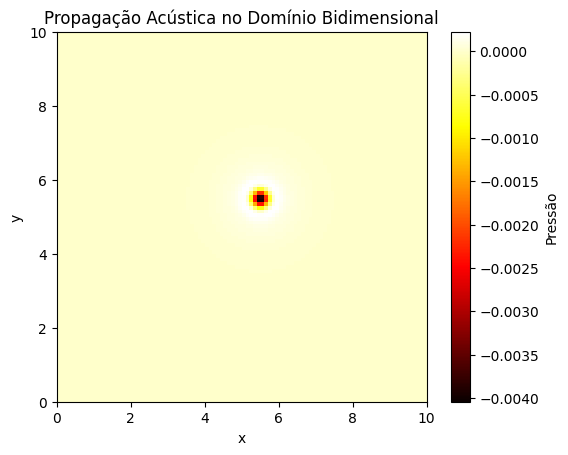

In [ ]:
# Gere os dados novamente
Lx = 10.0  # Comprimento no eixo x
Ly = 10.0  # Comprimento no eixo y
Nx = 100   # Número de pontos de grade no eixo x
Ny = 100   # Número de pontos de grade no eixo y
T = 5.0    # Tempo total
Nt = 100   # Número de passos de tempo
c = 1.0    # Velocidade do som
sigma = 0.1
omega = 6.28
x0 = 5.5
y0 = 5.5


input_data, output_data = gerar_dados(Lx, Ly, Nx, Ny, T, Nt, c, sigma, omega, x0, y0)
x, y, t = input_data[:, 0], input_data[:, 1], input_data[:, 2]
pa = output_data

# Reorganize pa para corresponder à forma do grid
pa_grid = pa.reshape((Nt, Nx, Ny))

# Selecione a distribuição de pressão apenas no último instante de tempo (t = 5 segundos)
pressao_final = pa_grid[-1]

# Visualização dos resultados
plt.imshow(pressao_final, extent=[0, Lx, 0, Ly], origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Pressão')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Propagação Acústica no Domínio Bidimensional')
plt.show()


In [ ]:
tf.compat.v1.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# input_data, output_data = gerar_dados(Lx, Ly, Nx, Ny, T, Nt, c)
# x, y, t = input_data[:, 0], input_data[:, 1], input_data[:, 2]
# pa = output_data

# Reorganize pa para corresponder à forma do grid
# pa_grid = pa.reshape((Nt, Nx, Ny))

# Selecione a distribuição de pressão apenas no último instante de tempo (t = 5 segundos)
# pressao_final = pa_grid[-1]

# # Crie um vetor para o eixo y secundário
# y_values = np.linspace(0, Ly, Ny)

# # Visualização dos resultados
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plote a distribuição de pressão
# im = ax1.imshow(pressao_final, cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower')

# # Adicione uma barra de cores
# cbar = fig.colorbar(im, ax=ax1)
# cbar.set_label('Pressão')

# # Defina o eixo y secundário como a distribuição de pressão ao longo do eixo y
# ax2 = ax1.twinx()
# ax2.plot(y_values, np.sum(pressao_final, axis=1), color='red', label='Distribuição de Pressão (eixo y)')
# ax2.set_ylabel('Distribuição de Pressão (eixo y)')
# ax2.legend(loc='upper right')

# # Defina os rótulos dos eixos
# ax1.set_xlabel('Eixo x')
# ax1.set_ylabel('Eixo y')

# # Adicione um título
# plt.title('Distribuição de Pressão no Último Instante de Tempo')

# plt.show()

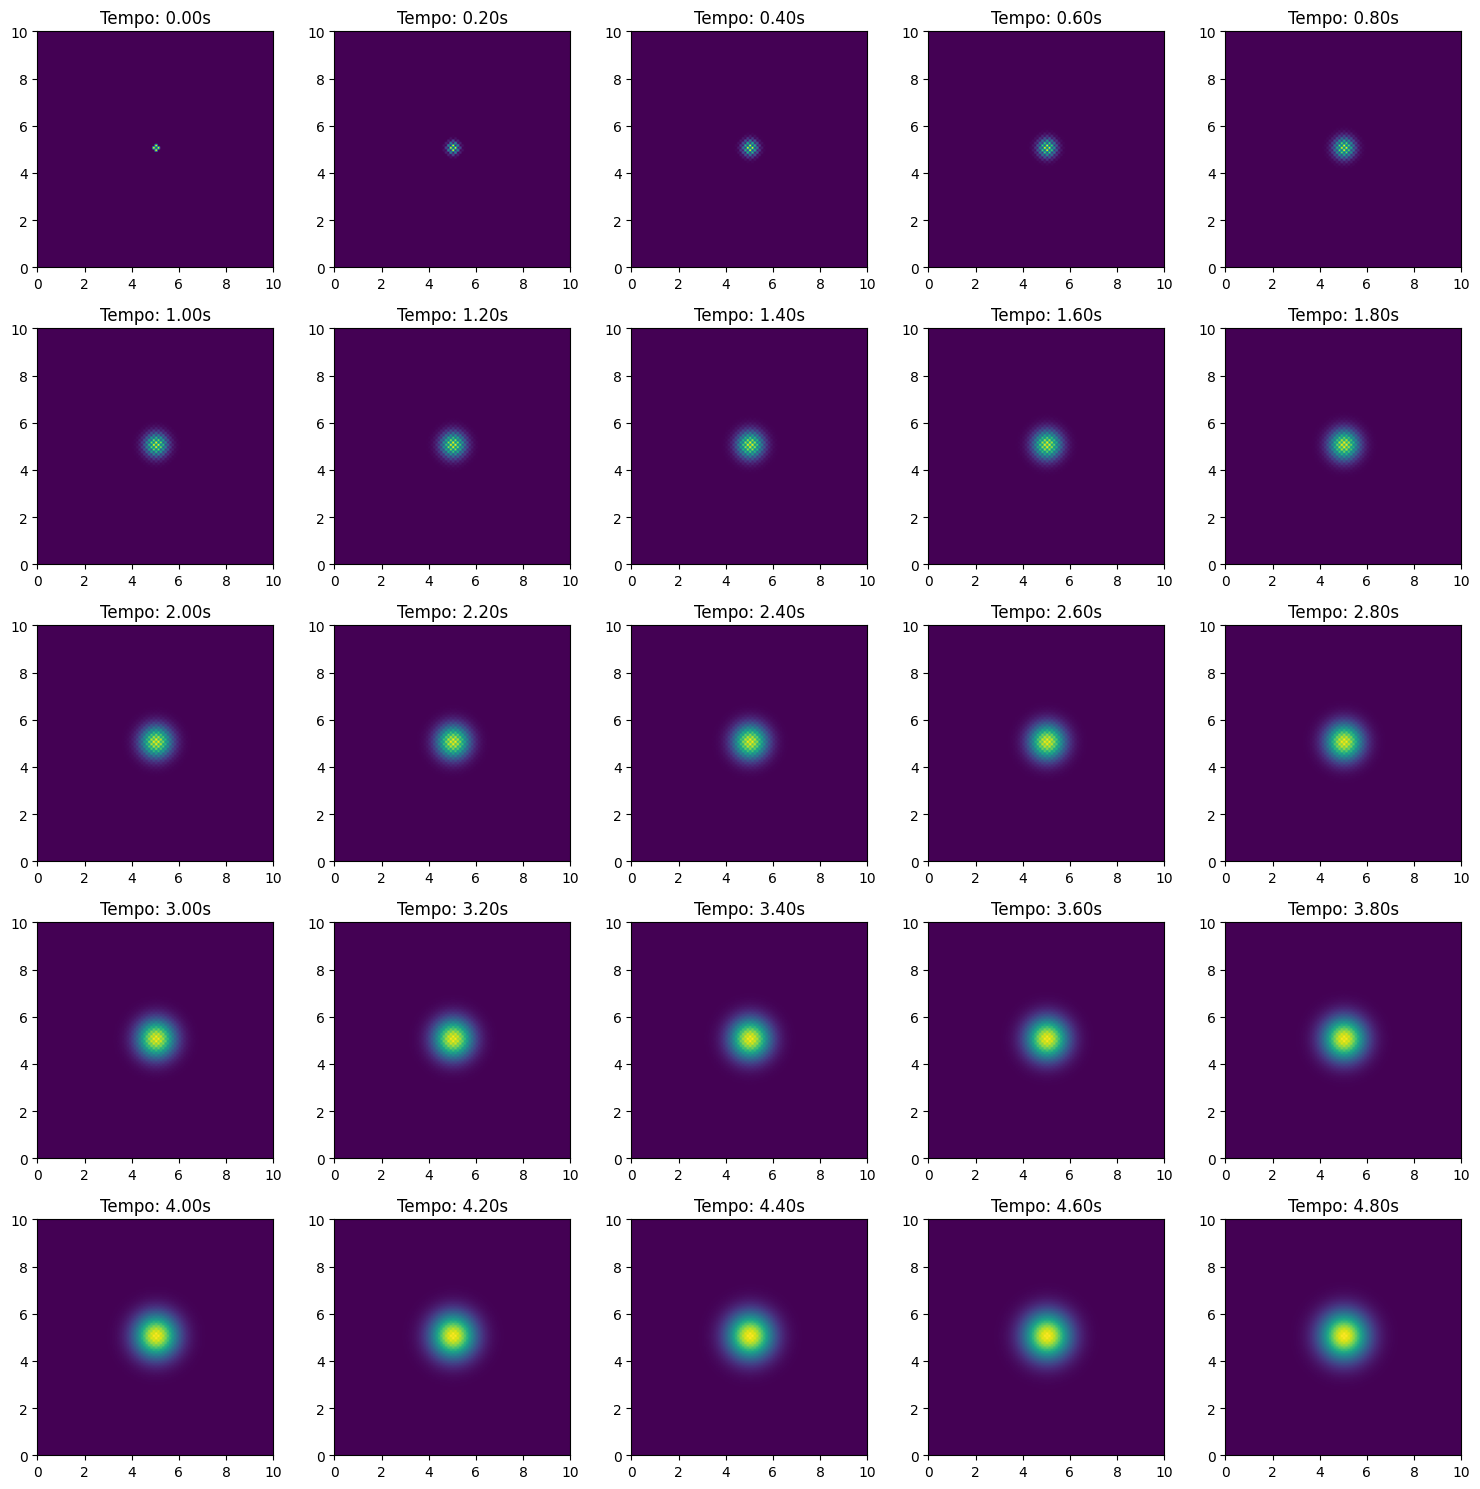

In [ ]:
# Gere os dados novamente
Lx = 10.0  # Comprimento no eixo x
Ly = 10.0  # Comprimento no eixo y
Nx = 100   # Número de pontos de grade no eixo x
Ny = 100   # Número de pontos de grade no eixo y
T = 5.0    # Tempo total
Nt = 100   # Número de passos de tempo
c = 1.0    # Velocidade do som

input_data, output_data = gerar_dados(Lx, Ly, Nx, Ny, T, Nt, c)
x, y, t = input_data[:, 0], input_data[:, 1], input_data[:, 2]
pa = output_data

# Reorganize pa para corresponder à forma do grid
pa_grid = pa.reshape((Nt, Nx, Ny))

# Visualização dos resultados
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for i in range(25):
    ax = axs[i // 5, i % 5]
    ax.imshow(pa_grid[i * 4, :, :], cmap='viridis', origin='lower', extent=[0, Lx, 0, Ly])
    ax.set_title(f'Tempo: {i * 4 * T / Nt:.2f}s')

plt.tight_layout()
plt.show()

### Old versions

In [ ]:
# Geração de dados para treinamento
def gerar_dados(tamanho_lote):
    # Gere dados aleatórios para x, y, t
    x = np.random.uniform(0, 5, tamanho_lote)
    y = np.random.uniform(0, 2, tamanho_lote)
    t = np.random.uniform(0, 6, tamanho_lote)

    A = 1.0  # Amplitude da onda
    f = 440.0  # Frequência da onda
    c = 343.0  # Velocidade do som

    coord_fonte = (1.5,1.0)

    pa = A* np.sin(2 * np.pi * f * t) * np.sqrt((
        x - coord_fonte[0])**2 + (y - coord_fonte[1])**2)/c # denominador (2 * 0.1**2)

    pa += np.random.normal(0, 0.1, tamanho_lote)

    x = np.expand_dims(x, axis=-1)
    y = np.expand_dims(y, axis=-1)
    t = np.expand_dims(t, axis=-1)

    return x, y, t, pa

# Defina a arquitetura da rede neural
class RedeNeural(tf.keras.Model):
    def __init__(self):
        super(RedeNeural, self).__init__()
        self.camada_oculta1 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.camada_oculta2 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')

        self.camada_saida = tf.keras.layers.Dense(1, activation=None)

    def call(self, entrada):
        x = self.camada_oculta1(entrada)
        x = self.camada_oculta2(x)
        return self.camada_saida(x)

# Função de perda
def perda_total(x, y, t, pa, modelo):
    with tf.GradientTape(persistent=True) as tape:
      # Converta para tensores TensorFlow
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        t = tf.convert_to_tensor(t, dtype=tf.float32)

        tape.watch(x)
        tape.watch(y)
        tape.watch(t)
    # Faça previsões usando a rede neural
        entrada = tf.concat([tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1),
                             tf.expand_dims(t, axis=-1)], axis=-1)
        previsoes = modelo(entrada)
    # Perda de dados
        perda_data = tf.reduce_mean(tf.square(previsoes - pa))
        # derivada_temporal_pred = tape.gradient(previsoes, t)
        derivada_temporal_pred = tape.gradient(tape.gradient(previsoes, t), t)
        derivada_espacial_x_pred = tape.gradient(previsoes, x)
        derivada_espacial_y_pred = tape.gradient(previsoes, y)
    derivada_espacial_x_pred2_x = tape.gradient(derivada_espacial_x_pred, x)
    derivada_espacial_y_pred2_y = tape.gradient(derivada_espacial_y_pred, y)

    A = 1.0  # Amplitude da onda
    f = 440.0  # Frequência da onda
    c = 343.0  # Velocidade do som
    coord_fonte = (1.5,1.0)

    # dist_fonte = np.sqrt((x - coord_fonte[0])**2 + (y - coord_fonte[1])**2) # distancia entre cada coordenada e a fonte
    # fonte = A * np.sin(2 * np.pi * f * (t - dist_fonte / c)) # expressao da fonte
    fonte = A* np.sin(2 * np.pi * f * t) * np.sqrt((
        x - coord_fonte[0])**2 + (y - coord_fonte[1])**2)/c # denominador (2 * 0.1**2)

      # Perda física pela eq. diferencial da onda acustica
    perda_physics = tf.reduce_mean(tf.square(
        derivada_temporal_pred - c**2 * (derivada_espacial_x_pred2_x + derivada_espacial_y_pred2_y) - fonte))

    # Perda total
    perda_total = perda_data + lambda_physics * perda_physics

    return perda_total

# Parâmetros do treinamento
lambda_physics = 1.0
learning_rate = 0.001
numero_epocas = 5000
tamanho_lote = 1000

# Inicialização do modelo e otimizador
modelo = RedeNeural()
otimizador = tf.optimizers.Adam(learning_rate=learning_rate)


# Treinamento do modelo
for epoca in range(numero_epocas):
    # Gere um lote de dados
    # x_batch, y_batch, t_batch = gerar_dados(tamanho_lote)
    x_batch, y_batch, t_batch, pa_batch = gerar_dados(tamanho_lote)
    # pa_batch = calcular_pressao_acustica(x_batch, y_batch, t_batch)

    # Otimização passo a passo
    with tf.GradientTape() as tape:
        perda = perda_total(x_batch, y_batch, t_batch, pa_batch, modelo)
    gradientes = tape.gradient(perda, modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, modelo.trainable_variables))

    # Imprima a perda a cada 100 épocas
    if (epoca + 1) % 100 == 0:
        print(f'Época {epoca + 1}, Perda: {perda.numpy()}')



Época 100, Perda: 20782.353515625
Época 200, Perda: 6981.49560546875
Época 300, Perda: 2912.075927734375
Época 400, Perda: 2369.93701171875
Época 500, Perda: 1771.842529296875
Época 600, Perda: 1230.3857421875
Época 700, Perda: 1218.409423828125
Época 800, Perda: 972.5819702148438
Época 900, Perda: 1035.79052734375
Época 1000, Perda: 744.0681762695312
Época 1100, Perda: 611.46337890625
Época 1200, Perda: 562.6580200195312
Época 1300, Perda: 546.6621704101562
Época 1400, Perda: 479.3535461425781
Época 1500, Perda: 411.9852294921875
Época 1600, Perda: 354.1128845214844
Época 1700, Perda: 326.9404602050781
Época 1800, Perda: 294.84576416015625
Época 1900, Perda: 317.11370849609375
Época 2000, Perda: 268.882080078125
Época 2100, Perda: 218.43856811523438
Época 2200, Perda: 231.6683349609375
Época 2300, Perda: 191.32528686523438
Época 2400, Perda: 176.0780029296875
Época 2500, Perda: 194.26248168945312
Época 2600, Perda: 161.34817504882812
Época 2700, Perda: 203.85853576660156
Época 2800, P

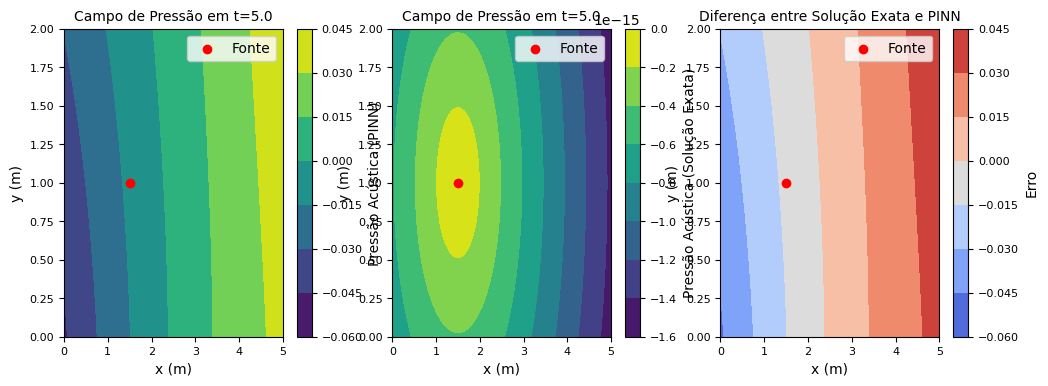

In [ ]:
num_pontos = 1000
x_grid, y_grid = np.meshgrid(np.linspace(0, 5, num_pontos), np.linspace(0, 2, num_pontos))
t_fixed_value = 5.0
t_fixed = np.ones_like(x_grid) * t_fixed_value  # Defina o instante de tempo desejado
x_grid_flat = x_grid.flatten()
y_grid_flat = y_grid.flatten()
t_fixed_flat = t_fixed.flatten()

# Faça previsões usando o modelo treinado
entrada_grid = np.column_stack((x_grid_flat, y_grid_flat, t_fixed_flat))
previsoes_grid = modelo(entrada_grid)
pa_pinn = np.reshape(previsoes_grid.numpy(), (num_pontos, num_pontos))

A = 1.0  # Amplitude da onda
f = 440.0  # Frequência da onda
c = 343.0  # Velocidade do som
coord_fonte = (1.5, 1.0)

solucao_exata = np.sin(2 * np.pi * f * t_fixed_flat) * np.exp(-((x_grid_flat - 0.5)**2 + (y_grid_flat - 0.5)**2) / (2 * 0.1**2))
pa_exato = A* np.sin(2 * np.pi * f * t_fixed_value) * np.sqrt(
    (x_grid - coord_fonte[0])**2 + (y_grid - coord_fonte[1])**2)/c

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
contour = plt.contourf(x_grid, y_grid, pa_pinn, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('Pressão Acústica (PINN)', fontsize=10)  # Tamanho da fonte na colorbar
plt.xlabel('x (m)', fontsize=10)  # Tamanho da fonte
plt.ylabel('y (m)', fontsize=10)  # Tamanho da fonte
plt.title(f'Campo de Pressão em t={t_fixed_value}', fontsize=10)  # Tamanho da fonte
plt.scatter(*coord_fonte, color='red', label='Fonte')
plt.xticks(fontsize=8)  # Tamanho dos números no eixo x
plt.yticks(fontsize=8)
cbar.ax.tick_params(labelsize=8)
plt.legend()

plt.subplot(1, 3, 2)
contour = plt.contourf(x_grid, y_grid, pa_exato, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('Pressão Acústica (Solução Exata)', fontsize=10)  # Tamanho da fonte na colorbar
plt.xlabel('x (m)', fontsize=10)  # Tamanho da fonte
plt.ylabel('y (m)', fontsize=10)  # Tamanho da fonte
plt.title(f'Campo de Pressão em t={t_fixed_value}', fontsize=10)  # Tamanho da fonte
plt.scatter(*coord_fonte, color='red', label='Fonte')
plt.xticks(fontsize=8)  # Tamanho dos números no eixo x
plt.yticks(fontsize=8)
cbar.ax.tick_params(labelsize=8)
plt.legend()

erro = pa_pinn - pa_exato
plt.subplot(1, 3, 3)
contour = plt.contourf(x_grid, y_grid, erro, cmap='coolwarm')
cbar = plt.colorbar(contour)
cbar.set_label('Erro', fontsize=10)  # Tamanho da fonte na colorbar
plt.xlabel('x (m)', fontsize=10)  # Tamanho da fonte
plt.ylabel('y (m)', fontsize=10)  # Tamanho da fonte
plt.title('Diferença entre Solução Exata e PINN', fontsize=10)  # Tamanho da fonte
plt.scatter(*coord_fonte, color='red', label='Fonte')
plt.xticks(fontsize=8)  # Tamanho dos números no eixo x
plt.yticks(fontsize=8)
cbar.ax.tick_params(labelsize=8)
plt.legend()

In [ ]:
# Geração de dados para treinamento
def gerar_dados(self, tamanho_lote):
    # Gere dados aleatórios para x, y, t
    x = np.random.uniform(0, 5, tamanho_lote)
    y = np.random.uniform(0, 2, tamanho_lote)
    t = np.random.uniform(0, 6, tamanho_lote)

    # Calcule a pressão acústica usando a solução exata
    A = 1.0  # Amplitude da onda
    f = 440.0  # Frequência da onda
    c = 343.0  # Velocidade do som
    coord_fonte = (1.5,1.0)

    # rotulos = A * np.sin(2 * np.pi * f * t * distancia_pulso / c)
    # pa = A* np.sin(2 * np.pi * f * t) * np.exp(-((
    #     x - coord_fonte[0])**2 + (y - coord_fonte[1])**2) / c) # denominador (2 * 0.1**2)
    rotulos = A* np.sin(2 * np.pi * f * t) * np.sqrt((
        x - coord_fonte[0])**2 + (y - coord_fonte[1])**2)/c # denominador (2 * 0.1**2)

    # Adicione algum ruído aos rótulos para torná-los mais realistas
    rotulos += np.random.normal(0, 0.1, tamanho_lote)

    # Expanda as dimensões para torná-las bidimensionais # ADICIONADO
    x = np.expand_dims(x, axis=-1)
    y = np.expand_dims(y, axis=-1)
    t = np.expand_dims(t, axis=-1)

    return x, y, t, rotulos

# Defina a arquitetura da rede neural
class RedeNeural(tf.keras.Model):
    def __init__(self):
        super(RedeNeural, self).__init__()
        self.camada_oculta1 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')
        self.camada_oculta2 = tf.keras.layers.Dense(100, activation='tanh', kernel_initializer='glorot_uniform')

        self.camada_saida = tf.keras.layers.Dense(1, activation=None)

    def call(self, entrada):
        x = self.camada_oculta1(entrada)
        x = self.camada_oculta2(x)
        return self.camada_saida(x)

# Função de perda
def perda_total(x, y, t, rotulos, modelo):
    with tf.GradientTape(persistent=True) as tape:
      # Converta para tensores TensorFlow
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        t = tf.convert_to_tensor(t, dtype=tf.float32)

        tape.watch(x)
        tape.watch(y)
        tape.watch(t)
    # Faça previsões usando a rede neural
        entrada = tf.concat([tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1),
                             tf.expand_dims(t, axis=-1)], axis=-1)
        previsoes = modelo(entrada)
    # Perda de dados
        perda_data = tf.reduce_mean(tf.square(previsoes - rotulos))
        # derivada_temporal_pred = tape.gradient(previsoes, t)
        derivada_temporal_pred = tape.gradient(tape.gradient(previsoes, t), t)
        derivada_espacial_x_pred = tape.gradient(previsoes, x)
        derivada_espacial_y_pred = tape.gradient(previsoes, y)
    derivada_espacial_x_pred2_x = tape.gradient(derivada_espacial_x_pred, x)
    derivada_espacial_y_pred2_y = tape.gradient(derivada_espacial_y_pred, y)

    c = 343.0

    dist_fonte = np.sqrt((x - 1.5)**2 + (y - 1.0)**2) # distancia entre cada coordenada e a fonte
    fonte = 1.0 * np.sin(2 * np.pi * 440.0 * (t - dist_fonte / c)) # expressao da fonte

    # Especificação do termo-fonte (exemplo simples)
    # x0, y0 = L / 2, L / 2  # Posição da fonte
    # g = np.sin(np.linspace(0, 2 * np.pi, Nt))  # Função temporal de excitação
    # f_source = np.outer(g, np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * (L / 10)**2)))

      # Perda física pela eq. diferencial da onda acustica
    perda_physics = tf.reduce_mean(tf.square(
        derivada_temporal_pred - c**2 * (derivada_espacial_x_pred2_x + derivada_espacial_y_pred2_y) - fonte))

    # Perda total
    perda_total = perda_data + lambda_physics * perda_physics

    return perda_total

# Parâmetros do treinamento
lambda_physics = 1.0
learning_rate = 0.001
numero_epocas = 1000
tamanho_lote = 1000

# Inicialização do modelo e otimizador
modelo = RedeNeural()
otimizador = tf.optimizers.Adam(learning_rate=learning_rate)


# Treinamento do modelo
for epoca in range(numero_epocas):
    # Gere um lote de dados
    x_batch, y_batch, t_batch, rotulos_batch = gerar_dados(tamanho_lote)

    # Otimização passo a passo
    with tf.GradientTape() as tape:
        perda = perda_total(x_batch, y_batch, t_batch, rotulos_batch, modelo)
    gradientes = tape.gradient(perda, modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, modelo.trainable_variables))

    # Imprima a perda a cada 100 épocas
    if (epoca + 1) % 100 == 0:
        print(f'Época {epoca + 1}, Perda: {perda.numpy()}')

# Visualização do campo de pressão em um domínio quadrado
# Aqui, você pode gerar uma grade de pontos no domínio quadrado e usar o modelo treinado para obter as previsões

# Gere uma grade de pontos no domínio quadrado
num_pontos = 1000
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, num_pontos), np.linspace(0, 1, num_pontos))
t_fixed_value = 5.0
t_fixed = np.ones_like(x_grid) * t_fixed_value  # Defina o instante de tempo desejado
x_grid_flat = x_grid.flatten()
y_grid_flat = y_grid.flatten()
t_fixed_flat = t_fixed.flatten()

# Faça previsões usando o modelo treinado
entrada_grid = np.column_stack((x_grid_flat, y_grid_flat, t_fixed_flat))
previsoes_grid = modelo(entrada_grid)
campo_pressao = np.reshape(previsoes_grid.numpy(), (num_pontos, num_pontos))

# Plote o campo de pressão
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, campo_pressao, cmap='viridis')
plt.colorbar()
plt.title(f'Campo de Pressão em t={t_fixed_value}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()




In [ ]:
# Gere uma grade de pontos no domínio quadrado
num_pontos = 1000
x_grid, y_grid = np.meshgrid(np.linspace(0, 2, num_pontos), np.linspace(0, 5, num_pontos))
t_fixed_value = 5.0
t_fixed = np.ones_like(x_grid) * t_fixed_value  # Defina o instante de tempo desejado
x_grid_flat = x_grid.flatten()
y_grid_flat = y_grid.flatten()
t_fixed_flat = t_fixed.flatten()

# Faça previsões usando o modelo treinado
entrada_grid = np.column_stack((x_grid_flat, y_grid_flat, t_fixed_flat))
previsoes_grid = modelo(entrada_grid)
campo_pressao = np.reshape(previsoes_grid.numpy(), (num_pontos, num_pontos))

# Plote o campo de pressão
plt.figure(figsize=(10, 8))
plt.contourf(x_grid, y_grid, campo_pressao, cmap='viridis')
plt.colorbar()
plt.title(f'Campo de Pressão em t={t_fixed_value}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
##########################################
coord_fonte = (1.5, 1.0)

plt.subplot(1, 3, 1)
contour = plt.contourf(x_grid, y_grid, campo_pressao, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('Pressão Acústica (Rede Neural)', fontsize=10)  # Tamanho da fonte na colorbar
plt.xlabel('x (m)', fontsize=10)  # Tamanho da fonte
plt.ylabel('y (m)', fontsize=10)  # Tamanho da fonte
plt.title(f'Campo de Pressão em t={t_fixed_value}', fontsize=10)  # Tamanho da fonte
plt.scatter(*coord_fonte, color='red', label='Fonte')
plt.xticks(fontsize=8)  # Tamanho dos números no eixo x
plt.yticks(fontsize=8)
cbar.ax.tick_params(labelsize=8)
plt.legend()

plt.subplot(1, 3, 2)
contour = plt.contourf(x_grid, y_grid, gerar_dados, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('Pressão Acústica (Solução Exata)', fontsize=10)  # Tamanho da fonte na colorbar
plt.xlabel('x (m)', fontsize=10)  # Tamanho da fonte
plt.ylabel('y (m)', fontsize=10)  # Tamanho da fonte
plt.title(f'Campo de Pressão em t={t_fixed_value}', fontsize=10)  # Tamanho da fonte
plt.scatter(*coord_fonte, color='red', label='Fonte')
plt.xticks(fontsize=8)  # Tamanho dos números no eixo x
plt.yticks(fontsize=8)
cbar.ax.tick_params(labelsize=8)
plt.legend()

diferenca = campo_pressao - gerar_dados
plt.subplot(1, 3, 3)
contour = plt.contourf(X, Y, diferenca, cmap='coolwarm')
cbar = plt.colorbar(contour)
cbar.set_label('Diferença', fontsize=10)  # Tamanho da fonte na colorbar
plt.xlabel('x (m)', fontsize=10)  # Tamanho da fonte
plt.ylabel('y (m)', fontsize=10)  # Tamanho da fonte
plt.title('Diferença entre a Solução Exata e a Rede Neural', fontsize=10)  # Tamanho da fonte
plt.scatter(*ponto_fonte, color='red', label='Fonte')
plt.xticks(fontsize=8)  # Tamanho dos números no eixo x
plt.yticks(fontsize=8)
cbar.ax.tick_params(labelsize=8)
plt.legend()

In [ ]:
# ... (código anterior)

# Gere uma grade de pontos no domínio quadrado
num_pontos = 1000
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, num_pontos), np.linspace(0, 1, num_pontos))
t_fixed_value = 5.0
t_fixed = np.ones_like(x_grid) * t_fixed_value  # Defina o instante de tempo desejado
x_grid_flat = x_grid.flatten()
y_grid_flat = y_grid.flatten()
t_fixed_flat = t_fixed.flatten()

# Solução Exata
A = 1.0  # Amplitude da onda
f = 1.0  # Frequência da onda
c = 1.0  # Velocidade do som

# Adicione um pulso acústico na posição (0.2, 0.5) na solução exata
# pulso_x = 0.5
# pulso_y = 0.5
# distancia_pulso = np.sqrt((x_grid_flat - pulso_x)**2 + (y_grid_flat - pulso_y)**2)
# pulso_exata = A * np.exp(-(distancia_pulso**2) / (2 * 0.1**2)) * np.sin(2 * np.pi * f * t_fixed_flat)


solucao_exata = np.sin(2 * np.pi * f * t_fixed_flat) * np.exp(-((x_grid_flat - 0.5)**2 + (y_grid_flat - 0.5)**2) / (2 * 0.1**2))


# Solução Aproximada
entrada_grid = np.column_stack((x_grid_flat, y_grid_flat, t_fixed_flat))
previsoes_grid = modelo(entrada_grid)
solucao_aproximada = np.reshape(previsoes_grid.numpy(), (num_pontos, num_pontos))


solucao_exata_ajustada = np.reshape(solucao_exata, (num_pontos, num_pontos))


# Erro entre Solução Exata e Aproximada
erro = solucao_exata_ajustada - solucao_aproximada

# Plote as quatro figuras
plt.figure(figsize=(20, 5))

# Plot 1: Solução Exata
plt.subplot(1, 4, 1)
plt.contourf(x_grid, y_grid, solucao_exata_ajustada, cmap='viridis')
plt.colorbar()
plt.title('Solução Exata')
plt.xlabel('X')
plt.ylabel('Y')

# Plot 2: Solução Aproximada
plt.subplot(1, 4, 2)
plt.contourf(x_grid, y_grid, solucao_aproximada, cmap='viridis')
plt.colorbar()
plt.title('Solução Aproximada')
plt.xlabel('X')
plt.ylabel('Y')

# Plot 3: Erro
plt.subplot(1, 4, 3)
plt.contourf(x_grid, y_grid, erro, cmap='viridis')
plt.colorbar()
plt.title('Erro (Exata - Aproximada)')
plt.xlabel('X')
plt.ylabel('Y')

# # Plot 4: Fonte (Pulso Acústico)
# plt.subplot(1, 4, 4)
# plt.contourf(x_grid, y_grid, pulso_exata, cmap='viridis')
# plt.colorbar()
# plt.title('Fonte (Pulso Acústico)')
# plt.xlabel('X')
# plt.ylabel('Y')

# # Exiba os plots
# plt.tight_layout()
# plt.show()


# Predict pressure from velocity

In this notebook, we will train a simple model to predict the pressure field from the velocity field. This is a simple example to demonstrate the use of the fields in this dataset.

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
# def loadCombinedArray(cases,field):
#     data = np.concatenate([np.load('/kaggle/input/ml-turbulence-dataset/'+dataset+'/'+dataset+'_'+case+'_'+field + '.npy') for case in cases])
#     return data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


For this simple example, we will use one case from the periodic hills dataset, simulated using the $k$-$\omega$-SST model in OpenFOAM.

In [ ]:
def loadCombinedArray(cases,field):
    data = np.concatenate([np.load(dataset+'/'+name+'_'+case+'_'+field + '.npy') for case in cases])
    return data

In [ ]:
dataset = '/content/drive/MyDrive/Colab_Notebooks/doutorado/ML_prediction/komegasst'
name = 'komegasst'
cases = ['BUMP_h20']

Here, we load the $x$ and $y$ coordinates of the fields, so we can visualize them later on.

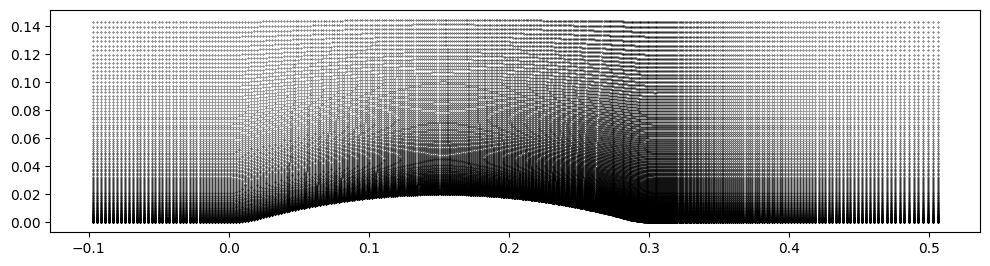

In [ ]:
x = loadCombinedArray(cases,'Cx')
y = loadCombinedArray(cases,'Cy')
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.scatter(x,y,c='k',s=0.1)
ax.set_aspect(1)

Now, let's load and visualize the velocity and pressure fields. Note that the tricontourf algorithm fills some areas below the curve of the hill, but the actual x and y coordinates our data are given on are shown above.

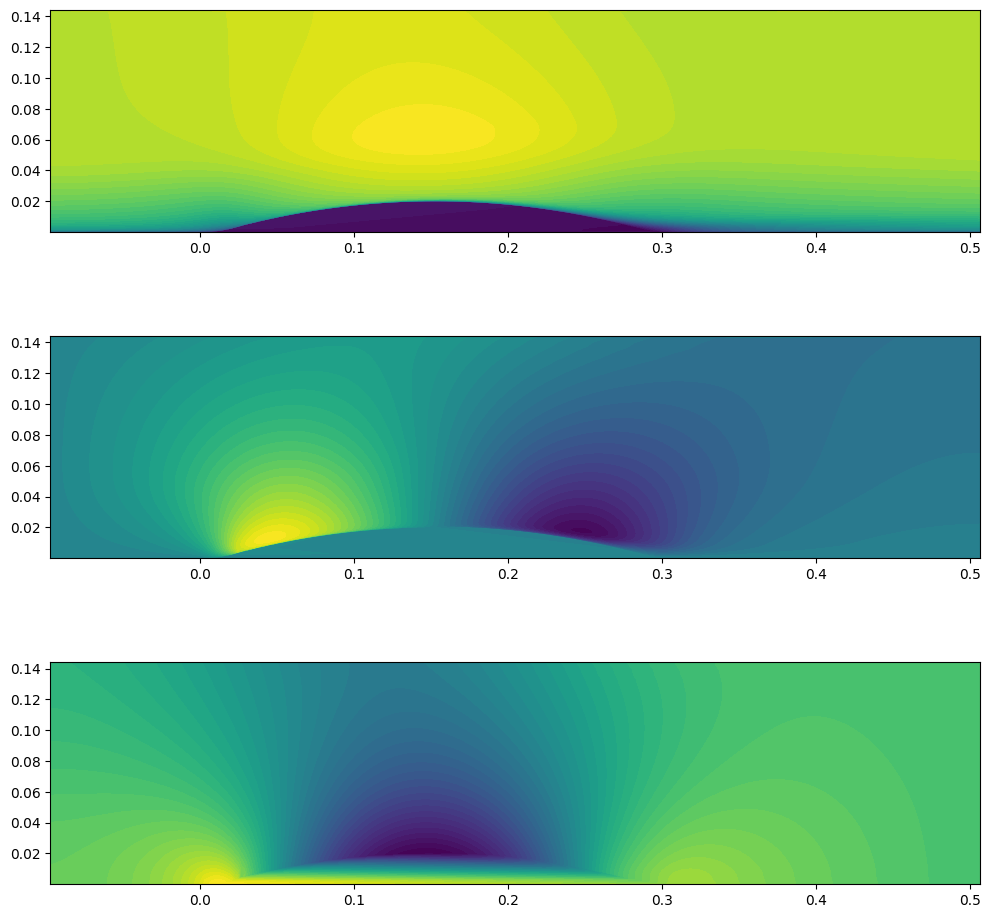

In [ ]:
Ux = loadCombinedArray(cases,'Ux')
Uy = loadCombinedArray(cases,'Uy')
p = loadCombinedArray(cases,'p')

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.tricontourf(x,y,Ux,levels=50)
ax1.set_aspect(1)
ax2.tricontourf(x,y,Uy,levels=50)
ax2.set_aspect(1)
ax3.tricontourf(x,y,p,levels=50)
ax3.set_aspect(1)

Let's prepare Ux and Uy as input features for a simple model to predict the pressure field.

Dataframe head: 
         Ux        Uy        p
0  0.400730  0.000004  4.66579
1  0.399585  0.000003  4.69542
2  0.398382  0.000004  4.73012
3  0.396849  0.000004  4.77903
4  0.395147  0.000005  4.83998
Dataframe summary: 
                 Ux            Uy             p
count  71103.000000  71103.000000  71103.000000
mean      13.017496     -0.183699     -9.765851
std        4.747880      0.885599     18.890100
min       -0.317555     -1.820490    -52.372600
25%       10.353500     -0.763332    -23.670150
50%       14.592400     -0.216985     -1.884190
75%       16.709850      0.147862      5.046380
max       18.689700      2.350120     21.891300
Dataframe histograms: 


array([[<Axes: title={'center': 'Ux'}>, <Axes: title={'center': 'Uy'}>],
       [<Axes: title={'center': 'p'}>, <Axes: >]], dtype=object)

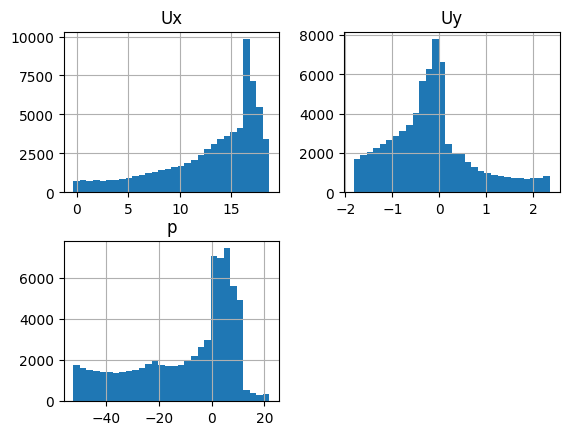

In [ ]:
from sklearn import preprocessing
import pandas as pd

data_combined = np.column_stack((Ux,Uy,p))
df = pd.DataFrame(data=data_combined)
df.columns=['Ux','Uy','p']
print('Dataframe head: ')
print(df.head())
print('Dataframe summary: ')
print(df.describe())
print('Dataframe histograms: ')
df.hist(bins=30)


For our example here, we aim to predict the pressure field from the velocity field. We separate the dataframe into a features and labels dataframe, and use the min-max scaler on both. This scales all the features and labels to range between 0 and 1.

array([[<Axes: title={'center': 'p'}>]], dtype=object)

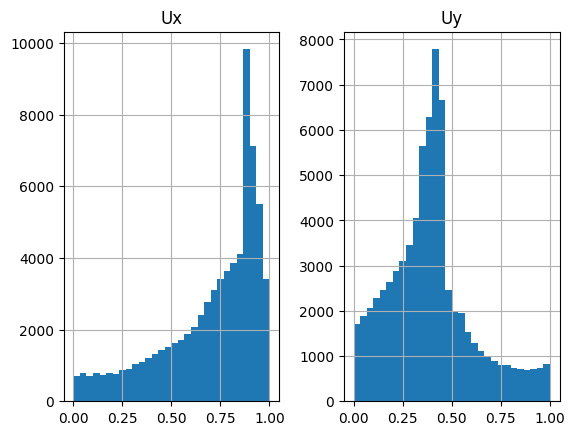

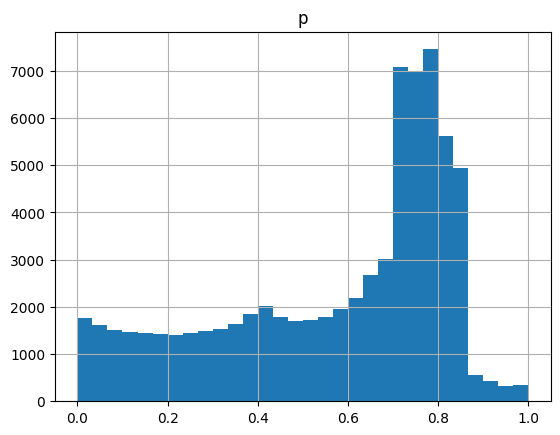

In [ ]:
df_features = df[['Ux','Uy']]
df_labels = df['p']

scaler_features = preprocessing.MinMaxScaler()
scaler_labels = preprocessing.MinMaxScaler()

df_features = pd.DataFrame(scaler_features.fit_transform(df_features), columns = ['Ux','Uy'])
df_labels = pd.DataFrame(scaler_labels.fit_transform(df_labels.values.reshape(-1,1)), columns = ['p'])

df_features.hist(bins=30)
df_labels.hist(bins=30)

Now, we build a neural network that takes the two velocity components as inputs, and outputs the pressure.

In [ ]:
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()

#The model has two inputs: Ux,Uy
input_layer = keras.layers.Input(shape=(2),name ='input_layer')

#Hidden layer definition
hidden1 = keras.layers.Dense(20,name='Hidden1', kernel_initializer="lecun_normal", activation = "selu")(input_layer)
hidden2 = keras.layers.Dense(20,name='Hidden2', kernel_initializer="lecun_normal", activation = "selu")(hidden1)
hidden3 = keras.layers.Dense(20,name='Hidden3', kernel_initializer="lecun_normal", activation = "selu")(hidden2)
hidden4 = keras.layers.Dense(20,name='Hidden4', kernel_initializer="lecun_normal", activation = "selu")(hidden3)
hidden5 = keras.layers.Dense(20,name='Hidden5', kernel_initializer="lecun_normal", activation = "selu")(hidden4)

output_layer = keras.layers.Dense(1,name='output_layer')(hidden5)

model=keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 Hidden1 (Dense)             (None, 20)                60        
                                                                 
 Hidden2 (Dense)             (None, 20)                420       
                                                                 
 Hidden3 (Dense)             (None, 20)                420       
                                                                 
 Hidden4 (Dense)             (None, 20)                420       
                                                                 
 Hidden5 (Dense)             (None, 20)                420       
                                                                 
 output_layer (Dense)        (None, 1)                 21    

We train the model now, for 100 epochs:

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 5E-4)
model.compile(optimizer,loss='mse',metrics=['mae', 'mse'])

history = model.fit([df_features], df_labels,
                    epochs=100,
                    verbose=1,
                   )

Epoch 1/100
2222/2222 [==============================] - 10s 3ms/step - loss: 0.0501 - mae: 0.1721 - mse: 0.0501
Epoch 2/100
2222/2222 [==============================] - 6s 2ms/step - loss: 0.0484 - mae: 0.1652 - mse: 0.0484
Epoch 3/100
2222/2222 [==============================] - 7s 3ms/step - loss: 0.0474 - mae: 0.1614 - mse: 0.0474
Epoch 4/100
2222/2222 [==============================] - 7s 3ms/step - loss: 0.0469 - mae: 0.1592 - mse: 0.0469
Epoch 5/100
2222/2222 [==============================] - 7s 3ms/step - loss: 0.0466 - mae: 0.1579 - mse: 0.0466
Epoch 6/100
2222/2222 [==============================] - 7s 3ms/step - loss: 0.0465 - mae: 0.1571 - mse: 0.0465
Epoch 7/100
2222/2222 [==============================] - 6s 3ms/step - loss: 0.0463 - mae: 0.1564 - mse: 0.0463
Epoch 8/100
2222/2222 [==============================] - 10s 4ms/step - loss: 0.0461 - mae: 0.1556 - mse: 0.0461
Epoch 9/100
2222/2222 [==============================] - 6s 3ms/step - loss: 0.0461 - mae: 0.1553 - ms

Now, let's visualize our model predictions.

2222/2222 [==============================] - 3s 1ms/step


Text(0.5, 1.0, 'Truth')

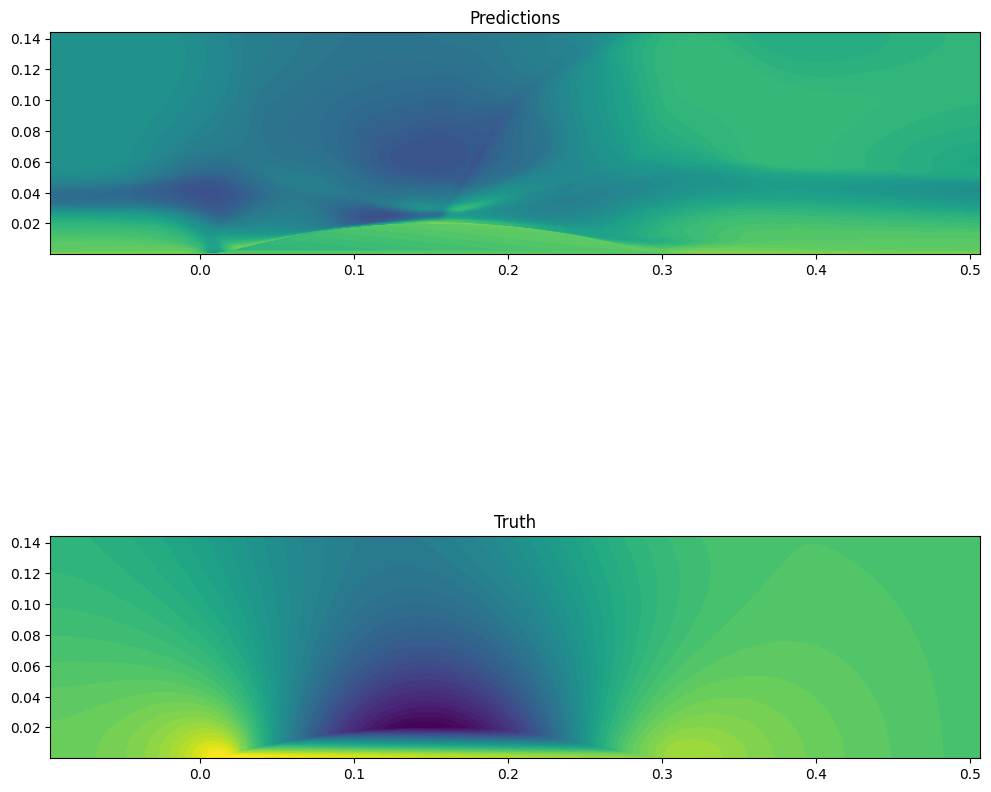

In [ ]:
predictions = model.predict(df_features).reshape(len(df_features))
truth = df_labels['p']

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.tricontourf(x,y,predictions,levels=50,vmin=0,vmax=1)
ax1.set_aspect(1)
ax1.set_title('Predictions')
ax2.tricontourf(x,y,truth,levels=50,vmin=0,vmax=1)
ax2.set_aspect(1)
ax2.set_title('Truth')


Our model struggles to predict the pressure field in the separated region, but does identify the acceleration on the right hill. Maybe, if we add the gradient of U as an input feature, the predictions will be better.

Let's see what these gradient fields looks like:

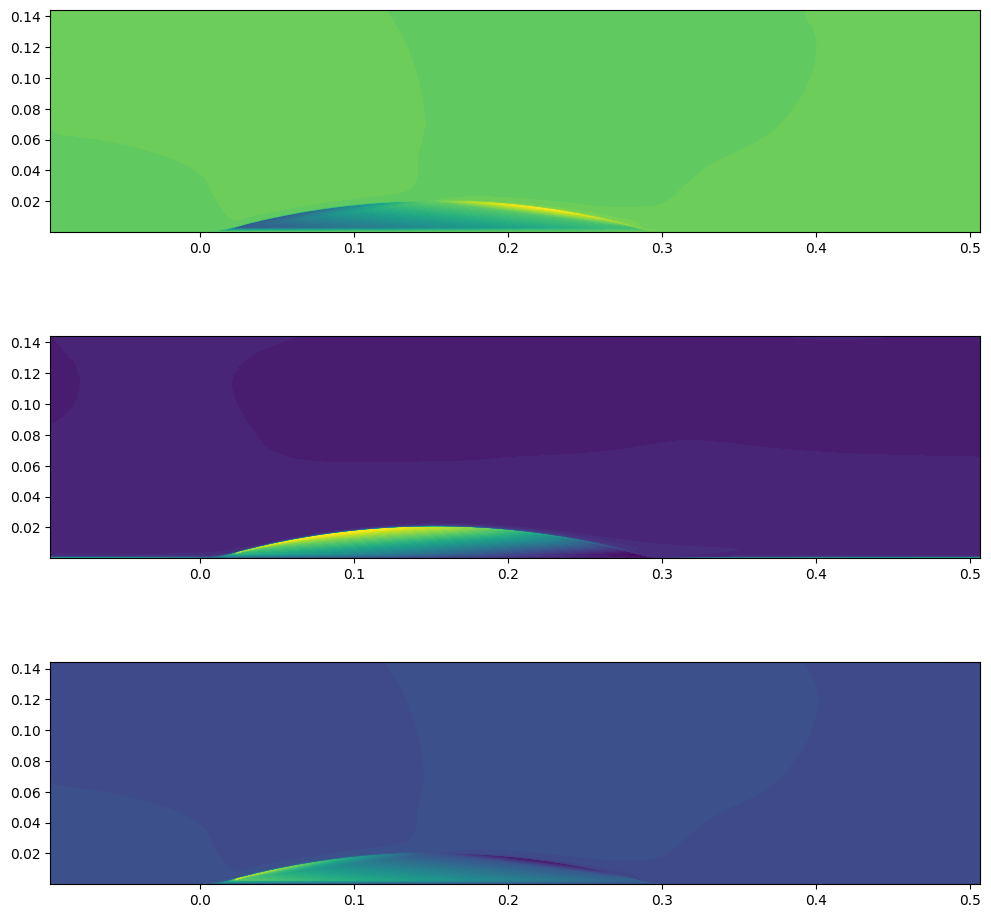

In [ ]:
gradU = loadCombinedArray(cases,'gradU')

gradUxx = gradU[:,0,0]
gradUxy = gradU[:,0,1]
gradUyy = gradU[:,1,1]
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.tricontourf(x,y,gradUxx,levels=50)
ax1.set_aspect(1)
ax2.tricontourf(x,y,gradUxy,levels=50)
ax2.set_aspect(1)
ax3.tricontourf(x,y,gradUyy,levels=50)
ax3.set_aspect(1)


Now, we re-generate our input feature dataframe, which now includes 5 inputs (Ux,Uy, gradUxx, gradUxy, and gradUyy).

Dataframe head: 
         Ux        Uy   gradUxx  gradUxy   gradUyy        p
0  0.400730  0.000004 -0.351071  16703.1  0.426205  4.66579
1  0.399585  0.000003 -0.395830  16660.8  0.409691  4.69542
2  0.398382  0.000004 -0.465681  16614.0  0.525480  4.73012
3  0.396849  0.000004 -0.555499  16554.4  0.611349  4.77903
4  0.395147  0.000005 -0.618291  16487.8  0.683694  4.83998
Dataframe summary: 
                 Ux            Uy       gradUxx       gradUxy       gradUyy  \
count  71103.000000  71103.000000  71103.000000  71103.000000  71103.000000   
mean      13.017496     -0.183699     13.275566   1112.388633    -13.277993   
std        4.747880      0.885599    360.002127   3205.868524    359.966861   
min       -0.317555     -1.820490  -7798.380000  -2418.400000  -2277.430000   
25%       10.353500     -0.763332     -9.379100     35.000950    -14.812650   
50%       14.592400     -0.216985      1.121650    150.289000     -1.122940   
75%       16.709850      0.147862     14.809300   

array([[<Axes: title={'center': 'p'}>]], dtype=object)

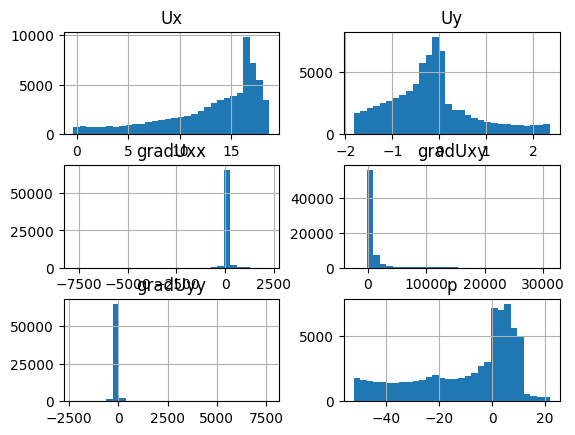

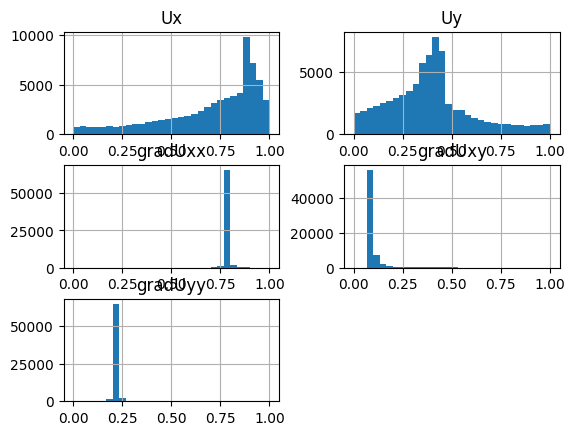

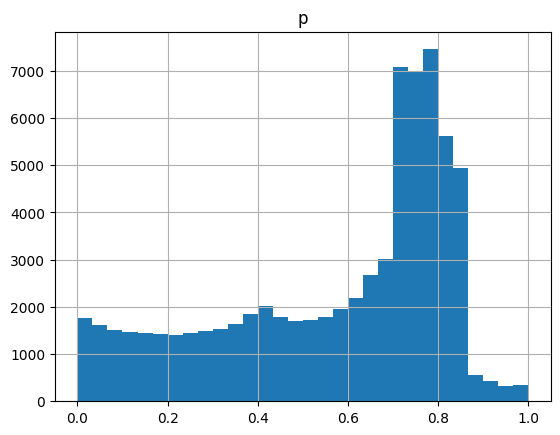

In [ ]:
data_combined = np.column_stack((Ux,Uy,gradUxx,gradUxy,gradUyy,p))
df = pd.DataFrame(data=data_combined)
df.columns=['Ux','Uy','gradUxx','gradUxy','gradUyy','p']
print('Dataframe head: ')
print(df.head())
print('Dataframe summary: ')
print(df.describe())
print('Dataframe histograms: ')
df.hist(bins=30)

df_features = df[['Ux','Uy','gradUxx','gradUxy','gradUyy']]
df_labels = df['p']

scaler_features = preprocessing.MinMaxScaler()
scaler_labels = preprocessing.MinMaxScaler()

df_features = pd.DataFrame(scaler_features.fit_transform(df_features), columns = ['Ux','Uy','gradUxx','gradUxy','gradUyy'])
df_labels = pd.DataFrame(scaler_labels.fit_transform(df_labels.values.reshape(-1,1)), columns = ['p'])

df_features.hist(bins=30)
df_labels.hist(bins=30)

In [ ]:
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()

#The model has two inputs: Ux,Uy
input_layer = keras.layers.Input(shape=(5),name ='input_layer')

#Hidden layer definition
hidden1 = keras.layers.Dense(20,name='Hidden1', kernel_initializer="lecun_normal", activation = "selu")(input_layer)
hidden2 = keras.layers.Dense(20,name='Hidden2', kernel_initializer="lecun_normal", activation = "selu")(hidden1)
hidden3 = keras.layers.Dense(20,name='Hidden3', kernel_initializer="lecun_normal", activation = "selu")(hidden2)
hidden4 = keras.layers.Dense(20,name='Hidden4', kernel_initializer="lecun_normal", activation = "selu")(hidden3)
hidden5 = keras.layers.Dense(20,name='Hidden5', kernel_initializer="lecun_normal", activation = "selu")(hidden4)

output_layer = keras.layers.Dense(1,name='output_layer')(hidden5)

model=keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5)]               0         
                                                                 
 Hidden1 (Dense)             (None, 20)                120       
                                                                 
 Hidden2 (Dense)             (None, 20)                420       
                                                                 
 Hidden3 (Dense)             (None, 20)                420       
                                                                 
 Hidden4 (Dense)             (None, 20)                420       
                                                                 
 Hidden5 (Dense)             (None, 20)                420       
                                                                 
 output_layer (Dense)        (None, 1)                 21    

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 5E-4)
model.compile(optimizer,loss='mse',metrics=['mae', 'mse'])

history = model.fit([df_features], df_labels,
                    epochs=100,
                    verbose=1,
                   )

Epoch 1/100
2222/2222 [==============================] - 10s 3ms/step - loss: 0.0275 - mae: 0.1241 - mse: 0.0275
Epoch 2/100
2222/2222 [==============================] - 6s 3ms/step - loss: 0.0173 - mae: 0.0926 - mse: 0.0173
Epoch 3/100
2222/2222 [==============================] - 6s 3ms/step - loss: 0.0126 - mae: 0.0787 - mse: 0.0126
Epoch 4/100
2222/2222 [==============================] - 6s 3ms/step - loss: 0.0097 - mae: 0.0700 - mse: 0.0097
Epoch 5/100
2222/2222 [==============================] - 7s 3ms/step - loss: 0.0079 - mae: 0.0635 - mse: 0.0079
Epoch 6/100
2222/2222 [==============================] - 6s 3ms/step - loss: 0.0070 - mae: 0.0596 - mse: 0.0070
Epoch 7/100
2222/2222 [==============================] - 7s 3ms/step - loss: 0.0061 - mae: 0.0557 - mse: 0.0061
Epoch 8/100
2222/2222 [==============================] - 6s 3ms/step - loss: 0.0056 - mae: 0.0534 - mse: 0.0056
Epoch 9/100
2222/2222 [==============================] - 7s 3ms/step - loss: 0.0050 - mae: 0.0506 - mse

2222/2222 [==============================] - 3s 1ms/step


Text(0.5, 1.0, 'Truth')

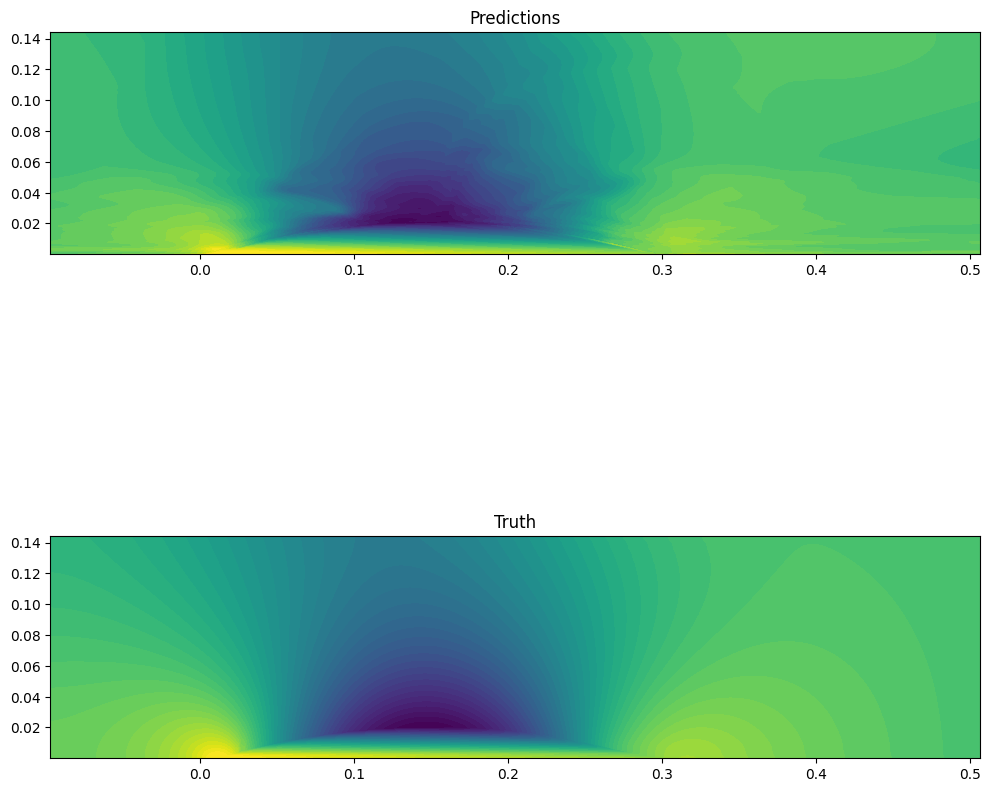

In [ ]:
predictions = model.predict(df_features).reshape(len(df_features))
truth = df_labels['p']

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.tricontourf(x,y,predictions,levels=50,vmin=0,vmax=1)
ax1.set_aspect(1)
ax1.set_title('Predictions')
ax2.tricontourf(x,y,truth,levels=50,vmin=0,vmax=1)
ax2.set_aspect(1)
ax2.set_title('Truth')

Adding these velocity gradients have improved the pressure field prediction. This is reflected in the better matching contour field, and the lower training mse in the second model.

Finally, let's see how well this model generalizes to a different periodic hills case: the steep $\alpha=0.5$ case.

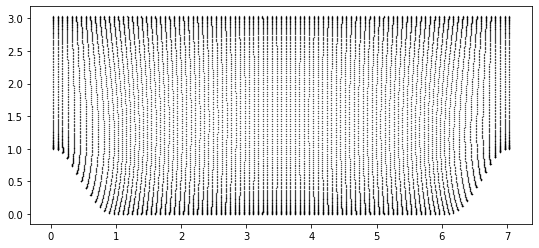

In [ ]:
dataset = 'komegasst'
cases = ['PHLL_case_0p5']
x = loadCombinedArray(cases,'Cx')
y = loadCombinedArray(cases,'Cy')
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.scatter(x,y,c='k',s=0.1)
ax.set_aspect(1)

Note that the scaler command has changed from fit_transform to transform (we use the same scaler the model was trained with, which has been fit on the $\alpha=1.0$ case.

Dataframe head: 
         Ux            Uy   gradUxx   gradUxy   gradUyy         p
0  0.001589  1.069070e-07  0.000029 -0.779814 -0.000089 -0.000080
1  0.001582 -5.934680e-08  0.000031 -0.776648  0.000002 -0.000078
2  0.001583  1.084560e-07  0.000042 -0.776101 -0.000096 -0.000075
3  0.001575  9.786830e-08  0.000080 -0.771853 -0.000110 -0.000072
4  0.001569  1.583580e-07  0.000097 -0.768229 -0.000153 -0.000069
Dataframe summary: 
                 Ux            Uy       gradUxx       gradUxy       gradUyy  \
count  14751.000000  14751.000000  14751.000000  14751.000000  14751.000000   
mean       0.016564      0.000183     -0.001368     -0.023283      0.001367   
std        0.013218      0.001162      0.022971      0.134579      0.022916   
min       -0.005698     -0.001412     -0.875224     -0.779967     -0.059868   
25%        0.001898     -0.000331     -0.000621     -0.011054     -0.001191   
50%        0.021129     -0.000024      0.000005      0.006402     -0.000005   
75%        0.0

Text(0.5, 1.0, 'Truth')

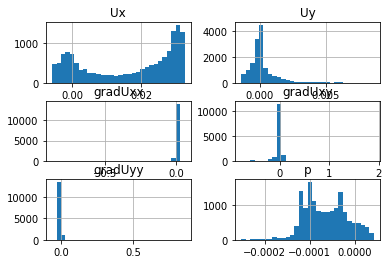

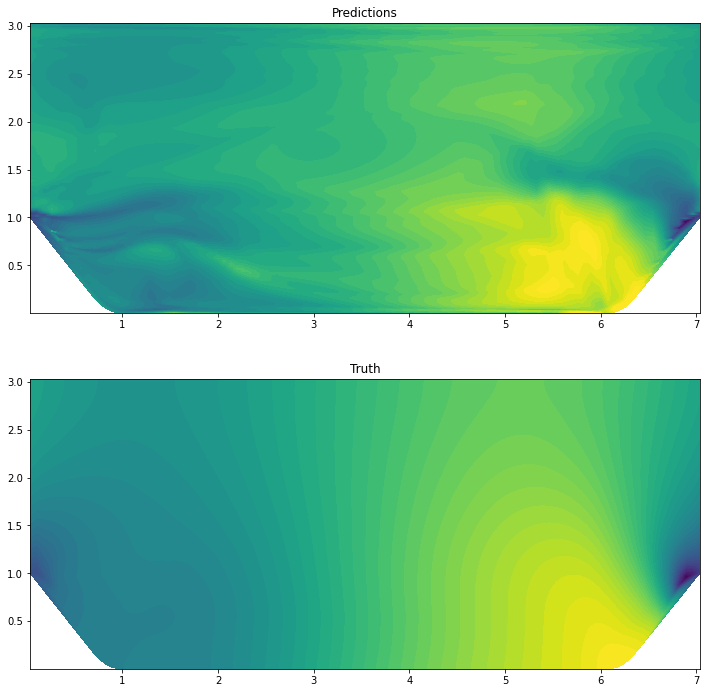

In [ ]:
data_combined = np.column_stack((Ux,Uy,gradUxx,gradUxy,gradUyy,p))
df = pd.DataFrame(data=data_combined)
df.columns=['Ux','Uy','gradUxx','gradUxy','gradUyy','p']
print('Dataframe head: ')
print(df.head())
print('Dataframe summary: ')
print(df.describe())
print('Dataframe histograms: ')
df.hist(bins=30)

df_features = df[['Ux','Uy','gradUxx','gradUxy','gradUyy']]
df_labels = df['p']

df_features = pd.DataFrame(scaler_features.transform(df_features), columns = ['Ux','Uy','gradUxx','gradUxy','gradUyy'])
df_labels = pd.DataFrame(scaler_labels.transform(df_labels.values.reshape(-1,1)), columns = ['p'])

predictions = model.predict(df_features).reshape(len(df_features))
truth = df_labels['p']

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.tricontourf(x,y,predictions,levels=50,vmin=0,vmax=1)
ax1.set_aspect(1)
ax1.set_title('Predictions')
ax2.tricontourf(x,y,truth,levels=50,vmin=0,vmax=1)
ax2.set_aspect(1)
ax2.set_title('Truth')

Interestingly, the model seems to predict similar trends in the pressure fields as for the $\alpha = 1.0$ case.

We can check the error on this test case:

In [ ]:
model.evaluate(df_features,df_labels)

461/461 [==============================] - 1s 1ms/step - loss: 0.0047 - mae: 0.0457 - mse: 0.0047


[0.0047065517865121365, 0.04574832692742348, 0.0047065517865121365]

These metrics are the loss (equal to mse in this case), mae, and mse for the test case.